In [4]:
import os
import cv2
import csv
import pandas as pd
from matplotlib import pyplot
import tensorflow
import keras

In [6]:
keras.__version__

'2.3.1'

In [58]:
!pip3 uninstall mask-rcnn --y


Found existing installation: mask-rcnn 2.1
Uninstalling mask-rcnn-2.1:
  Successfully uninstalled mask-rcnn-2.1


In [8]:
csv_path = '/home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/dataset/03-models/ob_model/workspace/trainig_demo/annotations/test.csv'
def read_csv(path):
    csv_list = list()
    with open(path, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
            csv_list.append(row)
    return csv_list[1:]
read_csv(csv_path)[0]

['/home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/dataset/00-screenshot/com.google.android.apps.docs.editors.docs/2.png',
 '2960',
 '1440',
 'clickable',
 '212',
 '749',
 '1228',
 '941']

In [9]:
# training dataset
anns = pd.read_csv(csv_path)
anns.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/home/kimsoohyun/00-Research/02-Graph/02-image...,2960,1440,clickable,212,749,1228,941
1,/home/kimsoohyun/00-Research/02-Graph/02-image...,2960,1440,clickable,0,2138,1440,2676
2,/home/kimsoohyun/00-Research/02-Graph/02-image...,2960,1440,clickable,496,1950,944,2664
3,/home/kimsoohyun/00-Research/02-Graph/02-image...,2960,1440,clickable,0,96,224,320
4,/home/kimsoohyun/00-Research/02-Graph/02-image...,2960,1440,clickable,0,1927,480,2119


In [10]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [11]:
class ClickableConfig(Config):

    # Give the configuration a recognizable name
    NAME = "clickable"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + steel defects

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    
# instantiating 
clickable_config = ClickableConfig()

In [12]:
# display image with masks and bounding boxes

# class that defines and loads the kangaroo dataset
class ClickableDataset(Dataset):
    def __init__(self, path):
        super().__init__(self)
        self.data_path = path
    
    def read_csv(self):
        csv_list = list()
        with open(self.data_path, 'r') as csv_file:
            reader = csv.reader(csv_file, delimiter=',')
            for row in reader:
                csv_list.append(row)
        return csv_list[1:]
    
    # load the dataset definitions
    # Override
    def load_dataset(self, is_train=True):
        # define one class
        self.add_class("", 1, "clickable")
        # define data locations
        img_list = self.read_csv()
        # find all images
        for img_info in img_list:
            image_id = img_info[0].split('/')[-2] + '_' + img_info[0].split('/')[-1]
            img_path = img_info[0]
            width = img_info[2]
            height = img_info[1]
            annot = img_info[4:7]
        
            self.add_image('dataset', image_id=image_id, 
                           width = width, height = height,
                           path=img_path, annotation=img_info)
            
    def load_image(self, image_id):
        info = self.image_info[image_id]
        img_path = info['path']
        img = cv2.imread(img_path)
        return img
        
        
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image 
    # Override
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        info_list = info['annotation']
        height = int(info['height'])
        width = int(info['width'])
        box = info_list[4:]
        
        # load XML
        # create one array for all masks, each on a different channel
        masks = zeros([height, width, 1], dtype='uint8')
        # create masks
        class_ids = list()
        row_s, row_e = int(box[1]), int(box[3])
        col_s, col_e = int(box[0]), int(box[2])
        masks[row_s:row_e, col_s:col_e, 0] = 1
        class_ids.append(self.class_names.index('clickable'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    # Override
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']




In [13]:
# train set
train_path = '/home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/dataset/03-models/ob_model/workspace/trainig_demo/annotations/train_r.csv'
train_set = ClickableDataset(train_path)
train_set.load_dataset('train')
train_set.prepare()

# validation set
validation_path = '/home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/dataset/03-models/ob_model/workspace/trainig_demo/annotations/test.csv'
validation_set = ClickableDataset(validation_path)
validation_set.load_dataset('val')
validation_set.prepare()


(2960, 1440, 3)


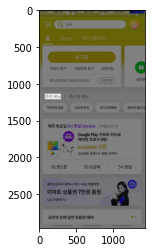

In [14]:
image_id = 'com.google.android.apps.docs.editors.docs_2.png'
image = train_set.load_image(100)
print(image.shape)
mask, class_ids = train_set.load_mask(100)
pyplot.imshow(image)
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

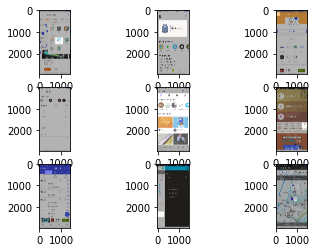

In [15]:
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    image = train_set.load_image(i)
    pyplot.imshow(image)
    # plot all masks
    mask, _ = train_set.load_mask(i)
    for j in range(mask.shape[2]):
        pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

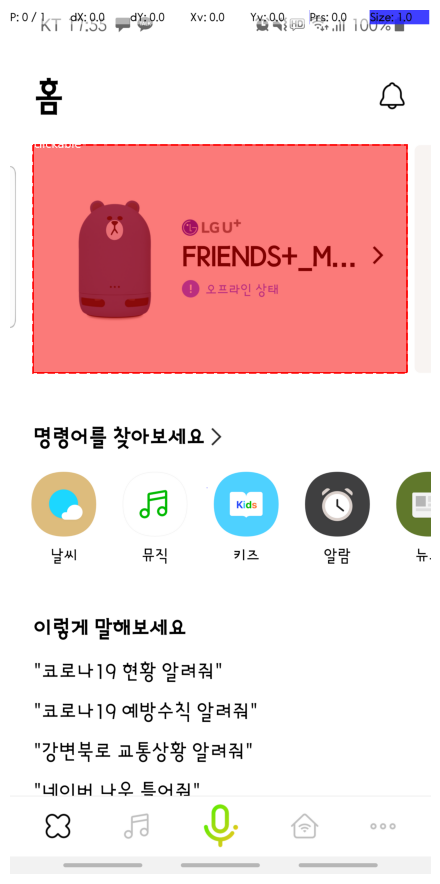

In [16]:
# define image id
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [17]:
model_path = '/home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/dataset/04-maskRCNN/model'

model = MaskRCNN(mode='training', model_dir=model_path, config=clickable_config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
model.train(train_set, validation_set, learning_rate=clickable_config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/dataset/04-maskRCNN/model/clickable20200426T2208/mask_rcnn_clickable_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2  

/home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/kimsoohyun/00-Research/02-Graph/02-image_detection/04-clickable/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Co

AttributeError: 'Model' object has no attribute '_get_distribution_strategy'